In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities')
from spatial_temporal_metrics import Metrics
import visualization

In [2]:
# load the ecland data as ground truth (ref)

# select 2021/2022 from Global dataset for the evaluation
# start with ecland_i6aj_o400_2010_2022_6h_euro.zarr
ecland_eval = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2021", "2022"))  
# train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr")  # Europe subset

# load the ailand data as mod

ailand_eval = xr.open_zarr("/home/ch23/data_ch23/xgbosst_train_2010_2019_val_2020_2020_est_50_hist.zarr")

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


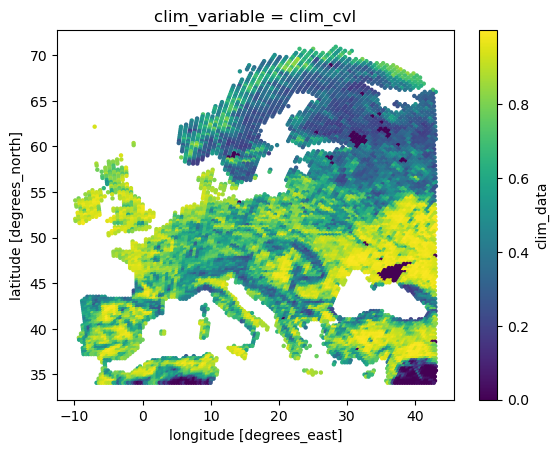

In [23]:
# visualize the spatial pattern of climate variables

ecland_eval.clim_data.sel(clim_variable="clim_cvl").to_dataset().plot.scatter(x="lon", y="lat", hue="clim_data", s=10, edgecolors="none") # always convert to xarray dataset first
plt.show()

In [3]:
# load the evaluation metrics file
eval_metrics_acc=xr.open_zarr("/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/acc.zarr")
eval_metrics_bias=xr.open_zarr("/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/bias.zarr")
eval_metrics_rmse=xr.open_zarr("/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/rmse.zarr")
eval_metrics_nor_rmse=xr.open_zarr("/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/nor_rmse.zarr")
eval_metrics_nor_rmse=xr.open_zarr("/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/nor_rmse.zarr")


In [104]:
# add climate variables from ecland to the dataframe

import pandas as pd


data = {}
climate_var_metrics=pd.DataFrame(data)
for var in ecland_eval['clim_variable']:
    climate_var_metrics[var] = ecland_eval.clim_data.sel(clim_variable="var").values
# add lat/lon from ecland to the dataframe
climate_var_metrics['lat']=ecland_eval['lat'].values
climate_var_metrics['lon']=ecland_eval['lon'].values

<xarray.Dataset> Size: 4GB
Dimensions:                     (x: 10051, clim_variable: 23, time: 2796,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 184B 'clim_cell_area' ...
    lat                         (x) float32 40kB 70.94 70.72 ... 34.07 34.07
    lon                         (x) float32 40kB 28.31 23.0 ... -0.7115 -0.3557
  * time                        (time) datetime64[ns] 22kB 2021-01-01 ... 202...
  * variable                    (variable) object 264B 'met_ctpf' ... 'es'
  * x                           (x) int32 40kB 15653 16004 ... 128483 128484
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 925kB dask.array<chunksize=(10051, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 4GB dask.array<chunksize=(4, 10051, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_means           (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_mins            (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>

In [92]:
# combine and convert eval metrics, and ecland climate variables from .nc file to .csv 
# column index are the name of var or the name of the index
# for metrics result, var_name_metric_name
for var in eval_metrics_acc['variable']:
    climate_var_metrics['%s_acc' % var] = eval_metrics_acc.data.sel(variable=var).values

<xarray.Dataset> Size: 161kB
Dimensions:   (x: 10051)
Coordinates:
    lat       (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
    lon       (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
    variable  <U5 20B 'snowc'
  * x         (x) int32 40kB 15653 16004 16006 16009 ... 128482 128483 128484
Data variables:
    data      (x) float32 40kB dask.array<chunksize=(1257,), meta=np.ndarray>

In [79]:
### cannot do like this, because here we just used the value range calculated based on clim_cvl bins, not really corresponding to the clim_cvl value

percentile_bins = np.percentile(ecland_eval.clim_data.sel(clim_variable="clim_cvl").values, np.arange(0, 110, 10))

# Ensure the bins are unique and sorted
percentile_bins = np.unique(percentile_bins)

# Group 'acc' by these 10% interval bins
grouped_bins = eval_metrics_acc.data.sel(variable='snowc').groupby_bins(ecland_eval.clim_data.sel(clim_variable="clim_cvl"), bins=percentile_bins)

# Perform operations on the grouped data
# Example: Compute the mean of 'acc' for each 10% interval bin
mean_acc_per_bin = grouped_bins.mean()

# Convert the result to a dataset for visualization or further analysis
#mean_acc_per_bin_ds = mean_acc_per_bin.to_dataset(name='mean_acc')

In [85]:
eval_metrics_acc.data.sel(variable='snowc').values

array([0.90156585, 0.92125714, 0.9119794 , ..., 0.86888736, 0.8230764 ,
       0.8491565 ], dtype=float32)

In [96]:
# how to link the spatial metrics and the climate feature -- groupby -- convert to pandas dataframe

eval_metrics_acc['variable']

<xarray.DataArray 'variable' (variable: 7)> Size: 140B
array(['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc'], dtype='<U5')
Coordinates:
  * variable  (variable) <U5 140B 'swvl1' 'swvl2' 'swvl3' ... 'stl3' 'snowc'

In [ ]:
# boxplot -- by percentile or by class

In [ ]:
# scatter plot -- flattern the xarray to .values

In [ ]:
# heatmap?